# Neural Network Approach for Document Categorization

use bi-directional LSTM with self attention

In [2]:
import re 
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Gensim
import gensim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## given a corpus clean each text in the collection

In [18]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))
    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,text_stopwords_removed))
    return abstract_lemmatized

def tokenize_prepare(df):
    # remove puncutations and number, then tokenize each text
    text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df.Abstract))
    len(text_tokenized)
    df['n_words']=list(map(lambda x:len(x),text_tokenized))
    #come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
    # bigram_freeze = bigram.freeze()
    abstract_lemmatized = prepare_token(text_tokenized)
    df['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
    # plot data
    fig,axs = plt.subplots(1,3,figsize=(25,5))
    categories = df.Domain.value_counts().index
    counts = df.Domain.value_counts().values
    axs[0].bar(categories, counts, width=0.5)
    axs[0].set_title("Domain Frquency")
    # categories = df.area.value_counts().index
    # counts = df.area.value_counts().values
    # axs[1].bar(categories, counts, width=0.5)
    # axs[1].set_title("Area Frquency")
    axs[1].hist(df.n_words)
    axs[1].set_title("abstract word count")
    axs[2].hist(df.n_words_removed,bins=30)
    axs[2].set_title("abstract without stop words word count")

    plt.show()
    return abstract_lemmatized,df



46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/tmp/ipykernel_31633/2251930101.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['Domain_No'] = df_paper.Domain.map(topic2num)
/tmp/ipykernel_31633/4293104228.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words']=list(map(lambda x:len(x),text_tokenized))
/tmp/ipykernel_31633/4293104228.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

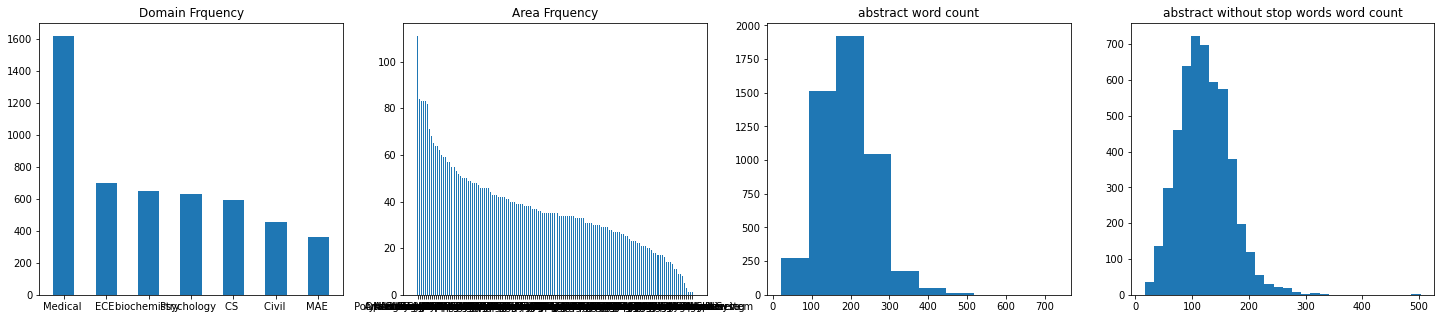

In [4]:
stop_words = stopwords.words('english')
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(5000) #use first 2000
print(df_paper.Domain.unique())
topic2num = {'CS ': 0, 'Medical ': 1, 'Civil ': 2, 'ECE ': 3, 'biochemistry ': 4, 'MAE ': 5, 'Psychology  ': 6}
df_paper['Domain_No'] = df_paper.Domain.map(topic2num)

abstract_lemmatized, df= tokenize_prepare(df_paper)



['use', 'study', 'patient', 'result', 'model', 'system', 'method', 'show', 'high', 'cell', 'control', 'c', 'data', 'increase', 'analysis', 'level', 'p', 'effect', 'present', 'propose', 'also', 'base', 'treatment', 'group', 'include', 'design', 'disease', 'compare', 'aim', 'may', 'low', 'associate', 'two', 'different', 'factor', 'time', 'provide', 'test', 'process', 'elsevier', 'expression', 'right', 'develop', 'well', 'year', 'approach', 'one', 'find', 'change', 'paper', 'risk', 'new', 'reserve', 'measure', 'gene']


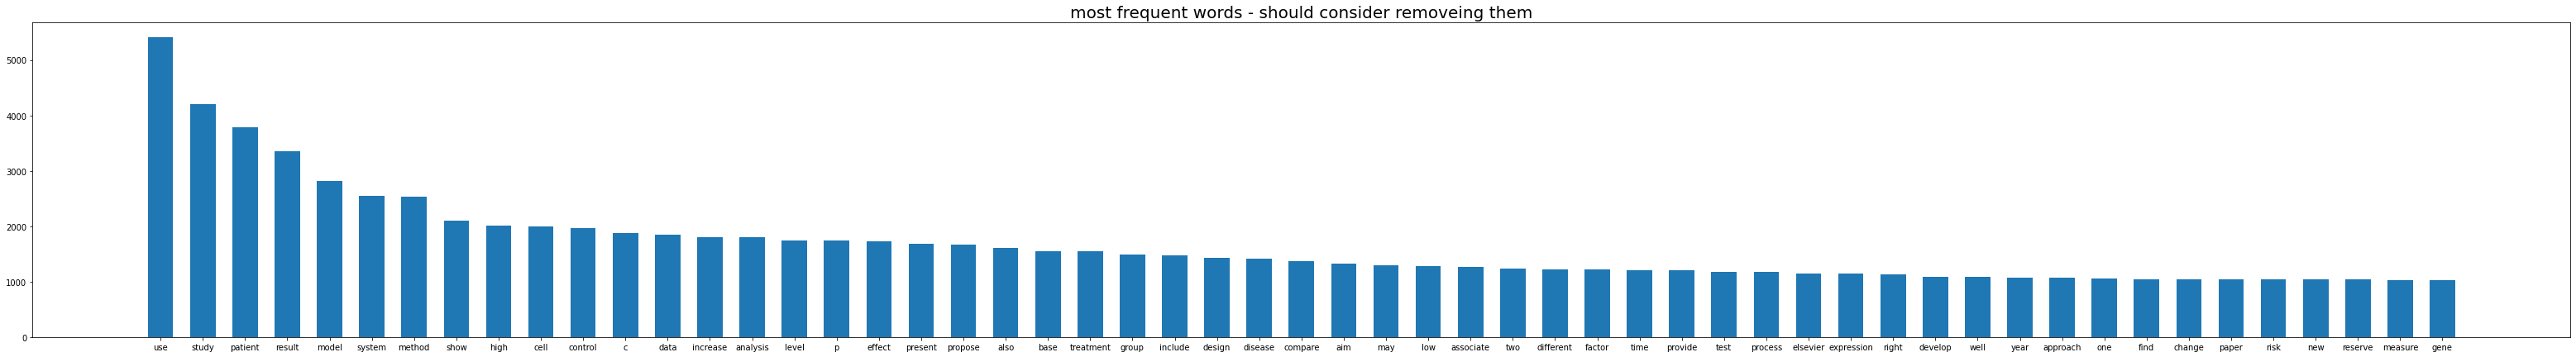

['expression', 'right', 'develop', 'well', 'year', 'approach', 'one', 'change', 'find', 'paper', 'risk', 'new', 'reserve', 'gene', 'measure', 'age', 'however', 'significant', 'significantly', 'health']


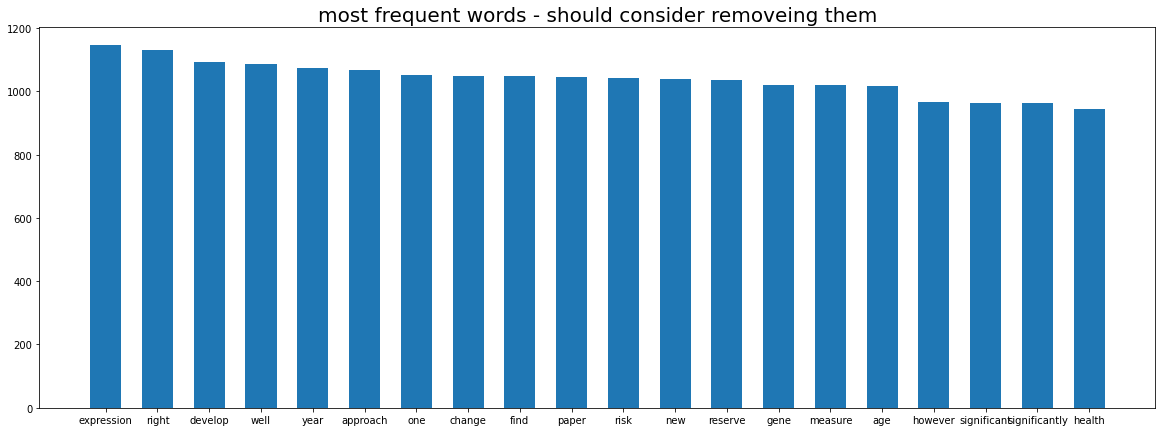

/tmp/ipykernel_31633/3453406941.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 105')

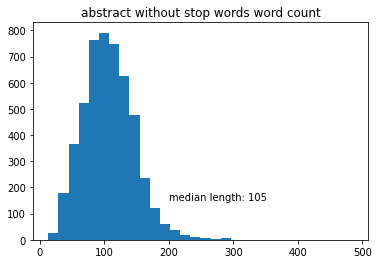

In [5]:
# remove popular words??
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

# remove top 50 most frequent words
top_n = list(count_df[:40].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)
df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)

In [6]:
list(map(lambda x:len(x),abstract_lemmatized_cleaned))

[120,
 168,
 65,
 88,
 119,
 110,
 83,
 81,
 147,
 117,
 88,
 146,
 135,
 92,
 53,
 160,
 58,
 120,
 97,
 108,
 66,
 101,
 52,
 66,
 126,
 133,
 115,
 107,
 164,
 172,
 148,
 144,
 101,
 116,
 168,
 172,
 114,
 138,
 119,
 199,
 226,
 166,
 146,
 207,
 101,
 110,
 115,
 149,
 167,
 206,
 167,
 122,
 150,
 100,
 93,
 60,
 149,
 97,
 58,
 119,
 64,
 136,
 74,
 64,
 107,
 133,
 139,
 61,
 83,
 69,
 150,
 95,
 122,
 116,
 112,
 71,
 97,
 136,
 87,
 43,
 162,
 68,
 86,
 98,
 82,
 74,
 64,
 101,
 70,
 101,
 124,
 125,
 84,
 145,
 131,
 49,
 184,
 103,
 111,
 108,
 42,
 57,
 96,
 150,
 103,
 184,
 55,
 50,
 120,
 60,
 103,
 101,
 34,
 65,
 123,
 120,
 109,
 52,
 72,
 159,
 151,
 85,
 96,
 71,
 57,
 51,
 34,
 83,
 61,
 60,
 53,
 89,
 55,
 74,
 108,
 102,
 95,
 42,
 91,
 49,
 73,
 150,
 83,
 125,
 50,
 87,
 51,
 61,
 47,
 119,
 69,
 67,
 86,
 60,
 129,
 88,
 106,
 126,
 80,
 103,
 134,
 81,
 88,
 65,
 57,
 117,
 99,
 52,
 71,
 136,
 151,
 95,
 91,
 92,
 61,
 113,
 244,
 109,
 83,
 46,
 94,
 122

## Building our Nerual Network
1. define and train word2vec from Gensim
2. apply word2vec on our documents 
3. input to the nerual network: vectorized document using word2vec
4. output: distribution of topics (a vector with length = # topics)

5. cross entropy function:

In [7]:
import gensim.downloader
from gensim.models import Word2Vec

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [8]:
print(np.shape(glove_vectors['medicine']))
print(np.shape(glove_vectors['water']))
#word vector/input dim = 100
global embedding_dim
embedding_dim = np.shape(glove_vectors['water'])[0]

(100,)
(100,)


In [11]:
# apply word2vec and vectorize corpus
def embed_w_word2vec(word):
    try:
        return glove_vectors[word]
    except:
        return np.zeros(embedding_dim) #unseen word -> zeros 

text_i = abstract_lemmatized_cleaned[0]
text_embedded = np.array(list(map(embed_w_word2vec, text_i)))
print("# unseen words:",np.sum(np.sum(text_embedded,axis=1)==0))

def applyGlove_corpus(abstract_lemmatized_cleaned,n_document,n_topics):
    corpus_embedded = list(map(lambda text_i: np.asarray(list(map(embed_w_word2vec, text_i))),abstract_lemmatized_cleaned[:n_document]))
    print(np.shape(corpus_embedded[1]))
    max_length = max(len(document) for document in corpus_embedded)
    X = np.array(list(map(lambda d: np.vstack([d,np.zeros((max_length-len(d),100))]),corpus_embedded)))
    return X

n_document = 1000
n_topics = 7
X = applyGlove_corpus(abstract_lemmatized_cleaned,n_document,n_topics)
# split into training and testing data
Y = np.array(df_paper.Domain_No[:n_document])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.25,)
print(np.shape(Y))
print(np.shape(X))


# unseen words: 8
(168, 100)
(1000,)
(1000, 259, 100)


In [ ]:
print(np.shape(X_train))

(750, 259, 100)


In [12]:
class myBi_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim,learning_rate=1e-2, device='cpu'):
        super().__init__()  
        self.device = device
        self.learning_rate = learning_rate

        if self.device == 'cuda':
            self.cuda() #net is for nueral network

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim #how to choose hidden_dim? 
        self.output_dim = output_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True,batch_first=True) #batch_first = True means using all documents to train once
        #self.concat = torch.cat(final hidden forward +final hidden backward) #concat the final forward and backward hidden state
        self.linear = nn.Linear(hidden_dim*2,output_dim)
        self.softmax = nn.Softmax() #just re-scaling to 0-1 -> probabilty and normalizing, input dim = output dim

        self.loss_func = nn.CrossEntropyLoss()

                #constructing optimizers, adam algorithm
        self.optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate,
        )


    def forward(self, X_t):
        """forward / predict."""
        #print("original dim", np.shape(X_t))
        lstmout,(hidden,cell_t) = self.lstm(X_t)
        #print("hidden state dim", np.shape(hidden))
        catout = torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)
        #print("catoutput dim:",np.shape(catout))
        linearout = self.linear(catout)
        #print("dim after linear", np.shape(linearout))
        out = self.softmax(linearout)
        #print("dim final:",np.shape(out))
        return out

    def update_network(self, y_hat, Y_t):
        """Update weights."""
        self.optimizer.zero_grad() #restart losses from last step, so error won't accumulate
        loss = self.loss_func(y_hat, Y_t) #compute loss by calling loss_func method
        loss.backward()
        self.optimizer.step()
        self.training_loss.append(loss.item())
        return loss.item()

    def calculate_accuracy(self, y_hat_class, Y):
        """Calculate accuracy."""
        return torch.sum(torch.eq(Y,y_hat_class)) / len(Y)

    def train(self, X, Y, n_iters=10):
        """Train network."""
        print("niters",n_iters)
        
        self.training_loss = []
        self.training_accuracy = []

        X_t = torch.FloatTensor(X).to(device=self.device)
        print(np.shape(X_t))
        #this is just writing our training np narray into tensor datatype. Tensor can run on both CPU and GPU(cuda)
        Y_t = torch.LongTensor(Y).to(device=self.device)

        for _ in range(n_iters):
            y_hat = self.forward(X_t)
            loss = self.update_network(y_hat, Y_t)
            y_hat_class = torch.argmax(y_hat,dim=1) # max probabilty -> text category
            accuracy = self.calculate_accuracy(y_hat_class, Y_t)
            self.training_accuracy.append(accuracy)
            print("%d iteration: train loss %.3f, train accuracy %.3f"% ( _, loss, accuracy))

    def plot_training_progress(self):
        """Plot training progress."""
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        ax[0].plot(self.training_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')

        ax[1].plot(self.training_accuracy)
        ax[1].set_ylabel('Classification Accuracy')
        ax[1].set_title('Training Accuracy')

        plt.tight_layout()
        plt.show()
    
    def predict(self,X_test):
        # take test data and return predictionas a numpy array
        X_t = torch.FloatTensor(X_test).to(device=self.device)
        Y_t_pred = self.forward(X_t)
        Y_t_class_pred = torch.argmax(Y_t_pred,dim=1)
        return Y_t_class_pred.detach().numpy()


niters 1000
torch.Size([750, 259, 100])


/tmp/ipykernel_31633/3464648344.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(linearout)


0 iteration: train loss 1.949, train accuracy 0.103
1 iteration: train loss 1.934, train accuracy 0.343
2 iteration: train loss 1.911, train accuracy 0.313
3 iteration: train loss 1.870, train accuracy 0.312
4 iteration: train loss 1.840, train accuracy 0.312
5 iteration: train loss 1.836, train accuracy 0.312
6 iteration: train loss 1.810, train accuracy 0.315
7 iteration: train loss 1.788, train accuracy 0.393
8 iteration: train loss 1.769, train accuracy 0.425
9 iteration: train loss 1.738, train accuracy 0.433
10 iteration: train loss 1.731, train accuracy 0.444
11 iteration: train loss 1.729, train accuracy 0.439
12 iteration: train loss 1.718, train accuracy 0.447
13 iteration: train loss 1.724, train accuracy 0.439
14 iteration: train loss 1.736, train accuracy 0.427
15 iteration: train loss 1.760, train accuracy 0.399
16 iteration: train loss 1.730, train accuracy 0.428
17 iteration: train loss 1.714, train accuracy 0.440
18 iteration: train loss 1.709, train accuracy 0.444
19 

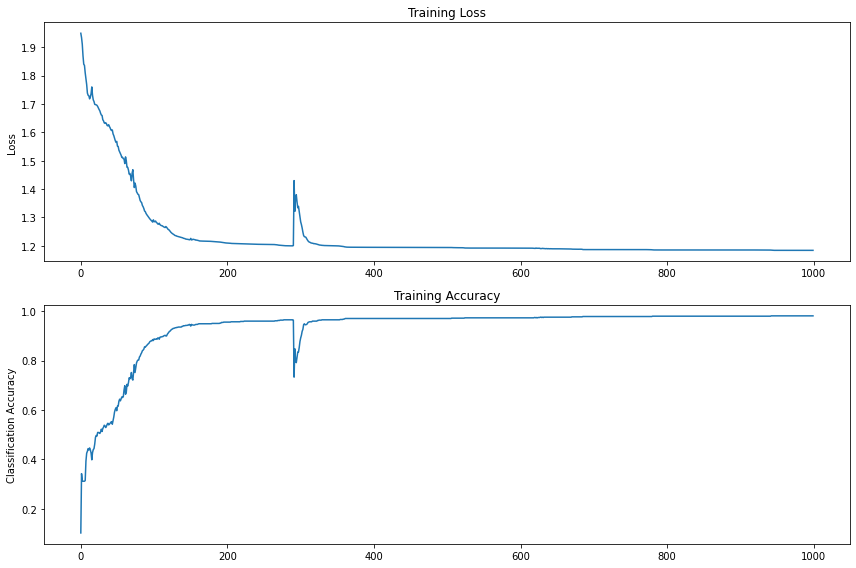

In [26]:

net = myBi_LSTM(embedding_dim=embedding_dim,hidden_dim=50,output_dim=n_topics)
net.train(X_train,Y_train,n_iters=500)
net.plot_training_progress()

In [ ]:
y_pred= net.predict(X_test)
test_accuracy = np.sum(y_pred==Y_test)/len(Y_test)
print("test accuracy",test_accuracy)

test accuracy 0.58


/tmp/ipykernel_31633/3464648344.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(linearout)


In [323]:
np.shape(Y_test)

(25,)

## apply LSTM to synthetic data

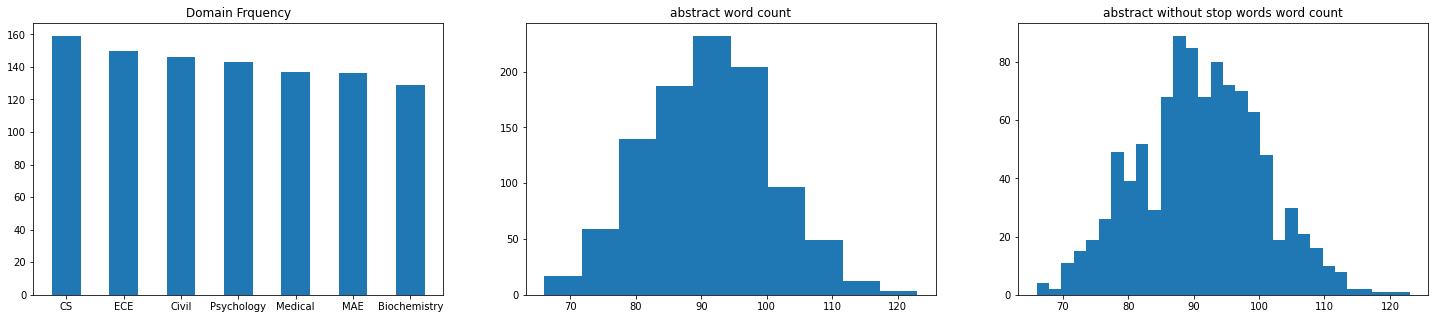

(87, 100)
(1000,)


In [20]:
# load and vectorize synthetic data with glove
mock_data = pd.read_csv("mockdata.csv", engine='python')
topic2num = {"CS": 0, "Civil":1, "MAE":2, "ECE":3, "Psychology":4, "Biochemistry":5,"Medical":6}
mock_data['Domain_No'] = mock_data.Domain.map(topic2num)
mock_data.head()

abstract_lemmatized, df= tokenize_prepare(mock_data)
n_document = 1000
n_topics = 7
mockX = applyGlove_corpus(abstract_lemmatized,n_document,n_topics)
# split into training and testing data
mockY = np.array(df_paper.Domain_No[:n_document])
mockX_train, mockX_test, mockY_train, mockY_test = train_test_split(mockX, mockY,test_size=0.25,)
print(np.shape(mockY))

In [27]:
mockdata_net = myBi_LSTM(embedding_dim=embedding_dim,hidden_dim=50,output_dim=n_topics)
mockdata_net.train(mockX_train,mockY_train,n_iters=500)
mockdata_net.plot_training_progress()

niters 1000
torch.Size([750, 123, 100])


/tmp/ipykernel_31633/3464648344.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(linearout)


0 iteration: train loss 1.945, train accuracy 0.136
1 iteration: train loss 1.929, train accuracy 0.319
2 iteration: train loss 1.904, train accuracy 0.319
3 iteration: train loss 1.865, train accuracy 0.319
4 iteration: train loss 1.847, train accuracy 0.319
5 iteration: train loss 1.847, train accuracy 0.319
6 iteration: train loss 1.847, train accuracy 0.319
7 iteration: train loss 1.847, train accuracy 0.319
8 iteration: train loss 1.847, train accuracy 0.319
9 iteration: train loss 1.847, train accuracy 0.319
10 iteration: train loss 1.847, train accuracy 0.319
11 iteration: train loss 1.847, train accuracy 0.319
12 iteration: train loss 1.847, train accuracy 0.319
13 iteration: train loss 1.847, train accuracy 0.319
14 iteration: train loss 1.846, train accuracy 0.319
15 iteration: train loss 1.846, train accuracy 0.319
16 iteration: train loss 1.846, train accuracy 0.319
17 iteration: train loss 1.846, train accuracy 0.320
18 iteration: train loss 1.846, train accuracy 0.320
19 

In [1]:
mockY_pred= mockdata_net.predict(mockX_test)
mock_test_accuracy = np.sum(mockY_pred==mockY_test)/len(mockY_test)
print("test accuracy",mock_test_accuracy)

NameError: name 'mockdata_net' is not defined